In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from epsilon_greedy import epsilon_greedy_algorithm


In this notebook, we implement the policy evaluator for finite data stream (https://arxiv.org/pdf/1003.5956.pdf)

The context of policy_evaluator depends for each algorithm, thus we can't implement a function that will be the same for every algorithm.

We have slightly modified the policy_evaluator. We consideer rewards as a list containing all the rewards value instead of a single number to be able to plot the cumulative average of our rewards.
We then don't need to add the parameter T as it will be the len of rewards.

In [140]:
def policy_evaluator_epsilon(dataframe, epsilon_value = 0.15):
    # We get the list of the arms (the movies)
    arms = dataframe['movie_id'].unique().tolist()
    # We initialize an empty history
    history = pd.DataFrame([], columns = dataframe.columns)
    # We stock the rewards in a list
    rewards = []
    for t in range(len(dataframe)):
        # We check our t-th row
        t_event = dataframe[t : t + 1]
        # If the movie recommended matches the movie of our dataframe, we update our history and our reward
        if epsilon_greedy_algorithm(history, arms, epsilon=epsilon_value, n_recommendations=1) == t_event['movie_id'].iloc[0] :
            history.loc[len(history)] = t_event.iloc[0].to_list()
            rewards.append(t_event['binary_rating'].iloc[0])
    return rewards
        

In [32]:
data = pd.read_csv('../Data/dataset_1000_minimum_reviews.csv', index_col='Unnamed: 0')
df = data[['time', 'movie_id', 'user_id', 'binary_rating']]
df.head()

,time,movie_id,user_id,binary_rating
0,0,1961,1107,1
1,1,1259,1545,0
2,2,595,3304,1
3,3,260,5448,0
4,4,1784,3829,0


In [141]:
rewards = policy_evaluator_epsilon(df, epsilon_value = 0.15)

In [142]:
pd.DataFrame(rewards).value_counts()

1    1148
0    1049
Name: count, dtype: int64

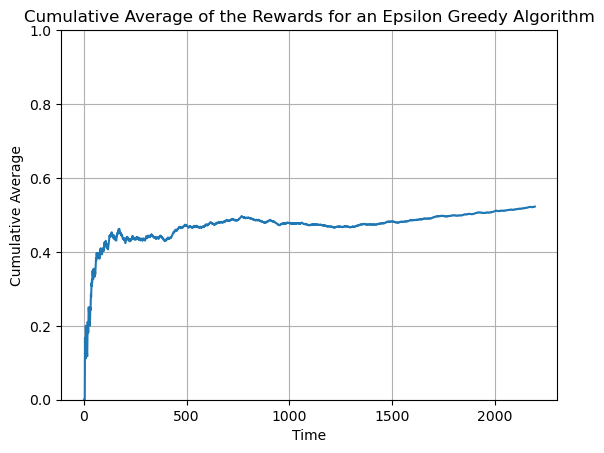

In [143]:
cumulative_average = np.cumsum(rewards) / np.arange(1, len(rewards)+1)

plt.plot(cumulative_average)
plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the Rewards for an Epsilon Greedy Algorithm")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

By using this exact strategy (observing the recommendation line by line), we realize that the policy evaluation is very bad. We thus propose a modification of the policy evaluation.

Instead of checking recommandations line by line, we check them by blocks. This means that for a block of size S, at each iteration t we ask our algorithm to recommend us S movies, and check if there are some S of these movies in our dataframe by looking the t*S+1, ... t*S+S rows. This isn't exactly the same as the Policy Evaluation in the research paper as it is possible that a recommendation made by the bandit algorithm can match with a row from the entire block, and not only the associated lign of the block.

In [112]:
def block_policy_evaluator_epsilon(dataframe, epsilon_value = 0.15, block_size=50):
    # We get the list of the arms (the movies)
    arms = dataframe['movie_id'].unique().tolist()
    # We initialize an empty history
    history = pd.DataFrame([], columns = dataframe.columns)
    # We stock the rewards in a list
    rewards = []
    for t in range(len(dataframe) // block_size):
        # As explained, we consideer a block and not a single observation
        time = t*block_size
        t_event = dataframe[time : time + block_size]
        # If recommendations matches the movies in our data, We update our history and reward
        recommendations = epsilon_greedy_algorithm(history, arms, epsilon=epsilon_value, n_recommendations=block_size)
        # We focus on the matches
        good_recommendations = t_event[t_event['movie_id'].isin(recommendations)]
        # We update our history
        history = pd.concat([history, good_recommendations])
        # We update the reward
        rewards.extend(good_recommendations['binary_rating'].to_list())
    return rewards

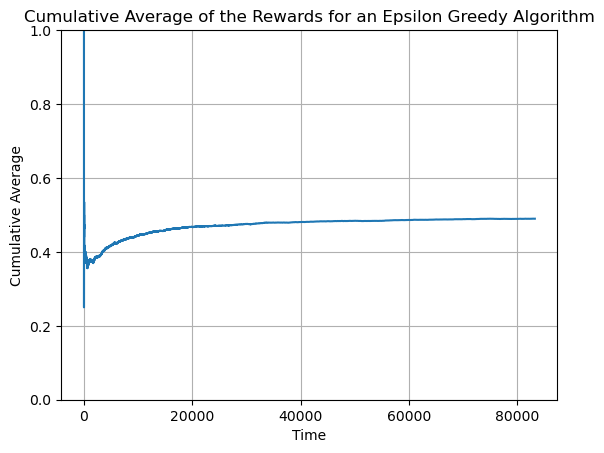

In [132]:
rewards_2 = block_policy_evaluator_epsilon(df, epsilon_value = 0.15)
cumulative_average = np.cumsum(rewards_2) / np.arange(1, len(rewards_2)+1)

plt.plot(cumulative_average)
plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the Rewards for an Epsilon Greedy Algorithm")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

The code above takes quite a long time to execute. Instead of concatenate each time, we just keep in memory the index of the rows that interest us so we don't need to concatenate each time it is required.

In [133]:
def block_policy_evaluator_epsilon_faster(dataframe, epsilon_value = 0.15, block_size=50):
    # We get the list of the arms (the movies)
    arms = dataframe['movie_id'].unique().tolist()
    # We initialize an empty history
    history_index = []
    # We stock the rewards in a list
    rewards = []
    for t in range(len(dataframe) // block_size):
        # As explained, we consideer a block and not a single observation
        time = t*block_size
        t_event = dataframe[time : time + block_size]
        # If recommendations matches the movies in our data, We update our history and reward
        history = pd.DataFrame(dataframe.loc[history_index])
        recommendations = epsilon_greedy_algorithm(history, arms, epsilon=epsilon_value, n_recommendations=block_size)
        # We focus on the matches
        good_recommendations = t_event[t_event['movie_id'].isin(recommendations)]
        # We update our history
        history_index.extend(good_recommendations.index.to_list())
        # We update the reward
        rewards.extend(good_recommendations['binary_rating'].to_list())
    return rewards

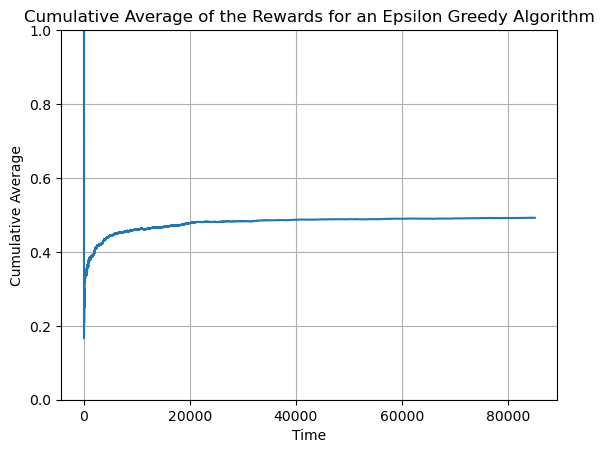

In [134]:
rewards_3 = block_policy_evaluator_epsilon_faster(df, epsilon_value = 0.15)
cumulative_average = np.cumsum(rewards_3) / np.arange(1, len(rewards_3)+1)

plt.plot(cumulative_average)
plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the Rewards for an Epsilon Greedy Algorithm")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

The code is around 2.5 times faster without concatenating.

We also wanted to implement a policy where the number of recommendations made were smaller than the size of the block.

In [136]:
def block_policy_evaluator_epsilon_2(dataframe, epsilon_value = 0.15, n_arms=5, block_size=50):
    # We get the list of the arms (the movies)
    arms = dataframe['movie_id'].unique().tolist()
    # We initialize an empty history
    history_index = []
    # We stock the rewards in a list
    rewards = []
    for t in range(len(dataframe) // block_size):
        # As explained, we consideer a block and not a single observation
        time = t*block_size
        t_event = dataframe[time : time + block_size]
        # If recommendations matches the movies in our data, We update our history and reward
        history = pd.DataFrame(dataframe.loc[history_index])
        recommendations = epsilon_greedy_algorithm(history, arms, epsilon=epsilon_value, n_recommendations=n_arms)
        # We focus on the matches
        good_recommendations = t_event[t_event['movie_id'].isin(recommendations)]
        # We update our history
        history_index.extend(good_recommendations.index.to_list())
        # We update the reward
        rewards.extend(good_recommendations['binary_rating'].to_list())
    return rewards

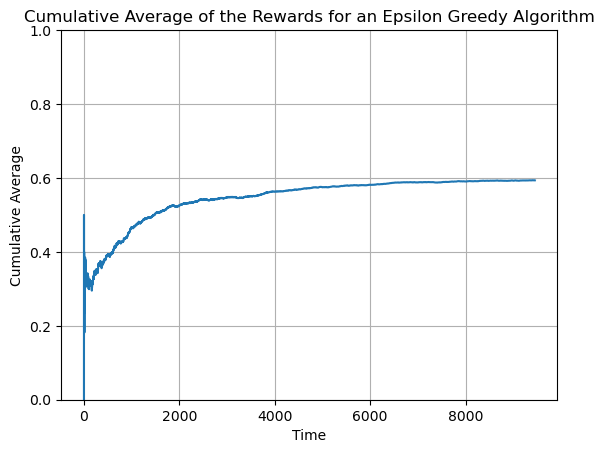

In [137]:
rewards_4 = block_policy_evaluator_epsilon_2(df, epsilon_value = 0.1, n_arms=5, block_size=50)
cumulative_average = np.cumsum(rewards_4) / np.arange(1, len(rewards_4)+1)

plt.plot(cumulative_average)
# plt.plot(pd.Series(rewards).rolling(200).mean(), label='epsilon')
plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the Rewards for an Epsilon Greedy Algorithm")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

Template for others bandit algorithms

In [ ]:
def policy_evaluator_bandit_algorithm(dataframe, ...):
    # We get the list of the arms (the movies)
    # arms = dataframe['movie_id'].unique().tolist() arms are potentially chosen in the loop, depending on our bandit algorithm
    
    # We initialize an empty history
    history = pd.DataFrame([], columns = dataframe.columns)
    # We stock the rewards in a list
    rewards = []
    for t in range(len(dataframe)):
        # We check our t-th row
        t_event = dataframe[t : t + 1]
        # If the movie recommended matches the movie of our dataframe, we update our history and our reward
        if epsilon_greedy_algorithm(history, arms, epsilon=epsilon_value, n_recommendations=1) == t_event['movie_id'].iloc[0] :
            history.loc[len(history)] = t_event.iloc[0].to_list()
            rewards.append(t_event['binary_rating'].iloc[0])
    return rewards
        

SyntaxError: invalid syntax (1289791643.py, line 1)